In [89]:
import gensim
#import fasttext as ft
import re
import itertools
from keras.layers.core import Activation, Dense, Dropout, SpatialDropout1D
from keras.layers.embeddings import Embedding
from keras.layers.wrappers import TimeDistributed
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
import collections 
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import time
import sys
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
start = time.time()

In [90]:
articles1 = pd.read_csv('articles_with_topics.csv')
articles = articles1.iloc[:1000,:]

In [91]:
articles.head()

,Unnamed: 0,id,title,publication,author,date,year,month,url,content,topics
0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...,"['republican', 'administration', 'health', 'su..."
1,1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood...","['police', 'band', 'arrest', 'crime', 'percent..."
2,2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri...","['1942', 'wong', 'artistic', 'miserable', 'chi..."
3,3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t...","['george', 'led', 'death', '“the', 'were', 'zs..."
4,4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ...","['ballistic', 'test', 'korea', 'missile', '1',..."


In [92]:
dictionary = list(articles.content)
def joinStrings(dictionary):
    return ' '.join(string for string in dictionary)

dictionary = joinStrings(dictionary)

In [93]:
dictionary = dictionary.lower()
chars = sorted(list(set(dictionary)))
char_to_int = dict((c, i) for i, c in enumerate(chars))

In [94]:
n_chars = len(dictionary)
n_vocab = len(chars)
print("Total characters:", n_chars)
print("Total Vocab:", n_vocab)

Total characters: 743978
Total Vocab: 74


In [95]:
seq_length = 100
dataX = []
dataY = []
for i in range(0, n_chars - seq_length, 1):
    seq_in = dictionary[i:i+seq_length]
    seq_out = dictionary[i+seq_length]
    dataX.append([char_to_int[char] for char in seq_in])
    dataY.append(char_to_int[seq_out])
n_patterns = len(dataX)

In [96]:
X = np.reshape(dataX, (n_patterns, seq_length, 1))
# normalize
X = X / float(n_vocab)
X_train = X[:int(0.75*len(X))]
X_val = X[int(0.75*len(X)):]
# one hot encode the output variable
y = np_utils.to_categorical(dataY)
y_train = y[:int(0.75*len(y))]
y_val = y[int(0.75*len(y)):]

In [97]:
y_val.shape

(185970, 74)

In [98]:
model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [99]:
#filepath="weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
filepath="weights-improvement-{epoch:02d}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [101]:
filename = "weights-improvement-10.hdf5"
model.load_weights(filename)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])


In [100]:
start_training = time.time()
history = model.fit(X_train, y_train, epochs=20, batch_size=128, callbacks=callbacks_list, validation_data = (X_val, y_val))
finish_training = time.time()
print('Training time = ', finish_training- start_training)

Train on 557908 samples, validate on 185970 samples
Epoch 1/10
557908/557908 [==============================] - 3201s 6ms/step - loss: 2.7336 - acc: 0.2272 - val_loss: 2.4979 - val_acc: 0.2728

Epoch 00001: loss improved from inf to 2.73363, saving model to weights-improvement-01.hdf5
Epoch 2/10
557908/557908 [==============================] - 3208s 6ms/step - loss: 2.4383 - acc: 0.2969 - val_loss: 2.2592 - val_acc: 0.3515

Epoch 00002: loss improved from 2.73363 to 2.43826, saving model to weights-improvement-02.hdf5
Epoch 3/10
557908/557908 [==============================] - 3219s 6ms/step - loss: 2.2747 - acc: 0.3449 - val_loss: 2.1261 - val_acc: 0.3882

Epoch 00003: loss improved from 2.43826 to 2.27470, saving model to weights-improvement-03.hdf5
Epoch 4/10
557908/557908 [==============================] - 3214s 6ms/step - loss: 2.1684 - acc: 0.3761 - val_loss: 2.0257 - val_acc: 0.4172

Epoch 00004: loss improved from 2.27470 to 2.16839, saving model to weights-improvement-04.hdf5


In [ ]:
filename = "weights-improvement-20.hdf5"
model.load_weights(filename)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])


In [102]:
int_to_char = dict((i, c) for i, c in enumerate(chars))

In [103]:
start = np.random.randint(0, len(dataX)-1)
pattern = dataX[start]
print("Seed:")
print("\"", ''.join([int_to_char[value] for value in pattern]), "\"")
# generate characters
for i in range(1000):
	x = np.reshape(pattern, (1, len(pattern), 1))
	x = x / float(n_vocab)
	prediction = model.predict(x, verbose=0)
	index = np.argmax(prediction)
	result = int_to_char[index]
	seq_in = [int_to_char[value] for value in pattern]
	sys.stdout.write(result)
	pattern.append(index)
	pattern = pattern[1:len(pattern)]

Seed:
" ts: a cue, a routine and a reward. to understand how to create habits  —   such as exercise habits   "
—   and the country and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second

In [104]:
#stopset = set(nltk.corpus.stopwords.words('english'))
def cleaner(x):
    x = nltk.word_tokenize(str(x))
    #x = [w for w in x if not w in stopset]
    x = [z.lower() for z in x]
    return x

articles.content = articles.content.map(lambda x:cleaner(x))

/home/ian/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [105]:
vocab = []
word = []
for i in range(len(articles.content)):
    for j in range(len(articles.content[i])):
        word.append(articles.content[i][j])
        if articles.content[i][j] not in vocab:
            vocab.append(articles.content[i][j])
#chars = list(set(data))
seq_length = 1
print('Data length: {} words'.format(len(word)))
print('Vocabulary size: {} words'.format(len(vocab)))

ix_to_word = {ix:word for ix, word in enumerate(vocab)}
word_to_ix = {word:ix for ix, word in enumerate(vocab)}

Data length: 146709 words
Vocabulary size: 13871 words


In [188]:
keywords = input(str("Enter some keywords or sentences. In case you're entering keywords, don't use comma separation."))

Enter some keywords or sentences. In case you're entering keywords, don't use comma separation.president politics


In [189]:
keys = keywords.split()
for i in keys:
    if i not in word_to_ix:
        keys.remove(i)

In [212]:
def joinStrings(dictionary):
            return ' '.join(string for string in dictionary)

articles.content = articles.content.map(lambda x:joinStrings(x))
if keys is None:
    print('Error! No keyword recognized!')
else:
    article = []
    for j in keys:
        new_dictionary = []
        for i in range(len(articles)):
            if j in articles.topics[i]:
                new_dictionary.append(articles.content[i])
        new_dictionary = joinStrings(new_dictionary)
        new_dictionary = new_dictionary.lower()
        #chars_new = sorted(list(set(new_dictionary)))
        #char_to_int = dict((c, i) for i, c in enumerate(chars))
        seq_length = 100
        dataX = []
        dataY = []
        for k in range(0, n_chars - seq_length, 1):
            seq_in = dictionary[k:k+seq_length]
            seq_out = dictionary[k+seq_length]
            dataX.append([char_to_int[char] for char in seq_in])
            dataY.append(char_to_int[seq_out])
        n_patterns = len(dataX)
        start = np.random.randint(0, len(dataX)-1)
        pattern = dataX[start]
        article.append(''.join([int_to_char[value] for value in pattern]))
        # generate characters
        for l in range(1000):
            x = np.reshape(pattern, (1, len(pattern), 1))
            x = x / float(n_vocab)
            prediction = model.predict(x, verbose=0)
            index = np.argmax(prediction)
            result = int_to_char[index]
            article.append(result)
            seq_in = [int_to_char[value] for value in pattern]
            sys.stdout.write(result)
            pattern.append(index)
            pattern = pattern[1:len(pattern)]
        article.append('.')

/home/ian/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


nd the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the sec

In [213]:
def convert(s):
    new = ""
    for x in s:
        new += x 
    return new
     
article = convert(article)

In [214]:
import distance

In [215]:
article = article.split()
for i in range(len(article)):
    if article[i] not in vocab and article[i] != '.':
        score = []
        for j in range(len(vocab)):
            score.append(distance.levenshtein(vocab[j], article[i]))
        article[i] = vocab[score.index(max(score))]
        
article = joinStrings(article)

In [216]:
print('Generated article:', article)

Generated article: a marginalization the transformational intergovernmental prince intergovernmental who had also been telecommunications was well enough to attend telecommunications the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the second and the sec

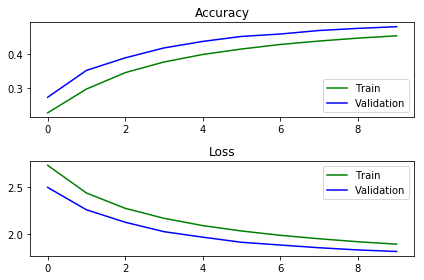

In [115]:
import matplotlib.pyplot as plt
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="Train")
plt.plot(history.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="Train")
plt.plot(history.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")
plt.tight_layout()

plt.show()

In [116]:
end = time.time()
print(end - start, 'seconds')

1523029300.2001002 seconds


'o'